## Group: Jingmin Chen, Tianyu Sun

# Introduction

In this project we'll using data science to help online retailers to predict the relationship between whether or not a visitor end up with a purchase and the actions it performed on the website. The dataset comes from UCI Machine Learning Repository.

My work contains following steps:
-   load data and understand meaning of each feature
-   perform some EDA and data preparation
-   using cluster algorithms to predict whether or not a visitor will end up with a purchase
-   training a SVM to predict on unseen data

The dataset not contains the end-up action of each visitor, so I have to explore it by myself. That's why I have to use cluster algorithms. I'll perform some exploration on cluster algorithms to find the best parameters. After that, the result predicted by cluster algorithms will be used as label.

In [1]:
# load python libraries
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score

## Load data

In this step I'll load the dataset from CSV file.

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/TTZUO/DAV-6150/master/Project2_Data.csv')

In [3]:
print(data.columns)
print(len(data.columns))

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend'],
      dtype='object')
17


There are 17 variables in the dataset with `Revenue` removed. Here is information of them I found on UCI Machine Learning website.

-   `Administrative`, `Administrative Duration`, `Informational`, `Informational Duration`, `Product Related` and `Product Related Duration` represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. 

-   `Bounce Rate` refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. 
-   `Exit Rate` calculated as for all pageviews to the page, the percentage that were the last in the session. 

-   `Page Value` the average value for a web page that a user visited before completing an e-commerce transaction. 

-   `Special Day` the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 

-   The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

The website says that there are 10 numerical variables and 7 categorial variables (without `Revenue`).

## EDA

In this step I'll perform some EDA work to explore some hidden information such as distribution of this dataset. And the result will help me to do data preparation in the future.

At first, I'll see the type of each variable and determain whether there are empty observations or not.

In [4]:
print(data.shape)

(12330, 17)


In [5]:
data.head(10)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.000000,0,0.00,8,222.000000,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True
1,0,0.000000,0,0.00,14,1037.500000,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False
2,4,37.500000,2,82.00,4,96.625000,0.000000,0.017500,0.000000,0.0,Nov,2,2,9,2,New_Visitor,False
3,4,115.700000,0,0.00,16,655.383333,0.000000,0.012037,0.000000,0.0,Nov,1,1,2,3,Returning_Visitor,False
4,1,60.000000,1,15.00,26,670.166667,0.000000,0.003846,0.000000,0.0,May,2,2,3,4,Returning_Visitor,False
5,4,44.000000,0,0.00,90,6951.972222,0.002151,0.015013,0.000000,0.0,Feb,4,1,1,3,Returning_Visitor,False
6,9,294.658788,2,97.64,107,3173.210417,0.003139,0.009122,5.866249,0.0,June,1,1,1,2,Returning_Visitor,False
7,1,0.000000,0,0.00,20,2270.833333,0.000000,0.023810,10.231873,0.0,Mar,2,2,3,6,Returning_Visitor,False
8,3,13.000000,0,0.00,7,79.500000,0.000000,0.020000,0.000000,0.0,Mar,2,2,1,8,New_Visitor,True
9,7,374.369048,0,0.00,5,258.083333,0.004545,0.052525,0.000000,0.0,May,3,2,3,1,Returning_Visitor,False


In [6]:
print(data.dtypes)

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
dtype: object


In [9]:
# check if there are empty data
print(data.isna().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
dtype: int64


The result shows that there are no empty observations. But numerical variable (with type `float64`) is fewer then 10, so I have to find rest numerical variable.

Combining the observations and the description of each variable, I found that:
-   Categorial variables: `Month`, `OperatingSystem`, `Browser`, `Region`, `TrafficType`, `VisitorType`, `Weekend`
-   Numerical variables: `Administrative`, `Administrative_Duration`, `Informational`, `Informational_Duration`, `ProductRelated`, `ProductRelated_Duration`, `BounceRates`, `ExitRates`, `PageValues`, `SpecialDay`

Now I can use figures to see the distributions of each variable.

The categorial variables goes first

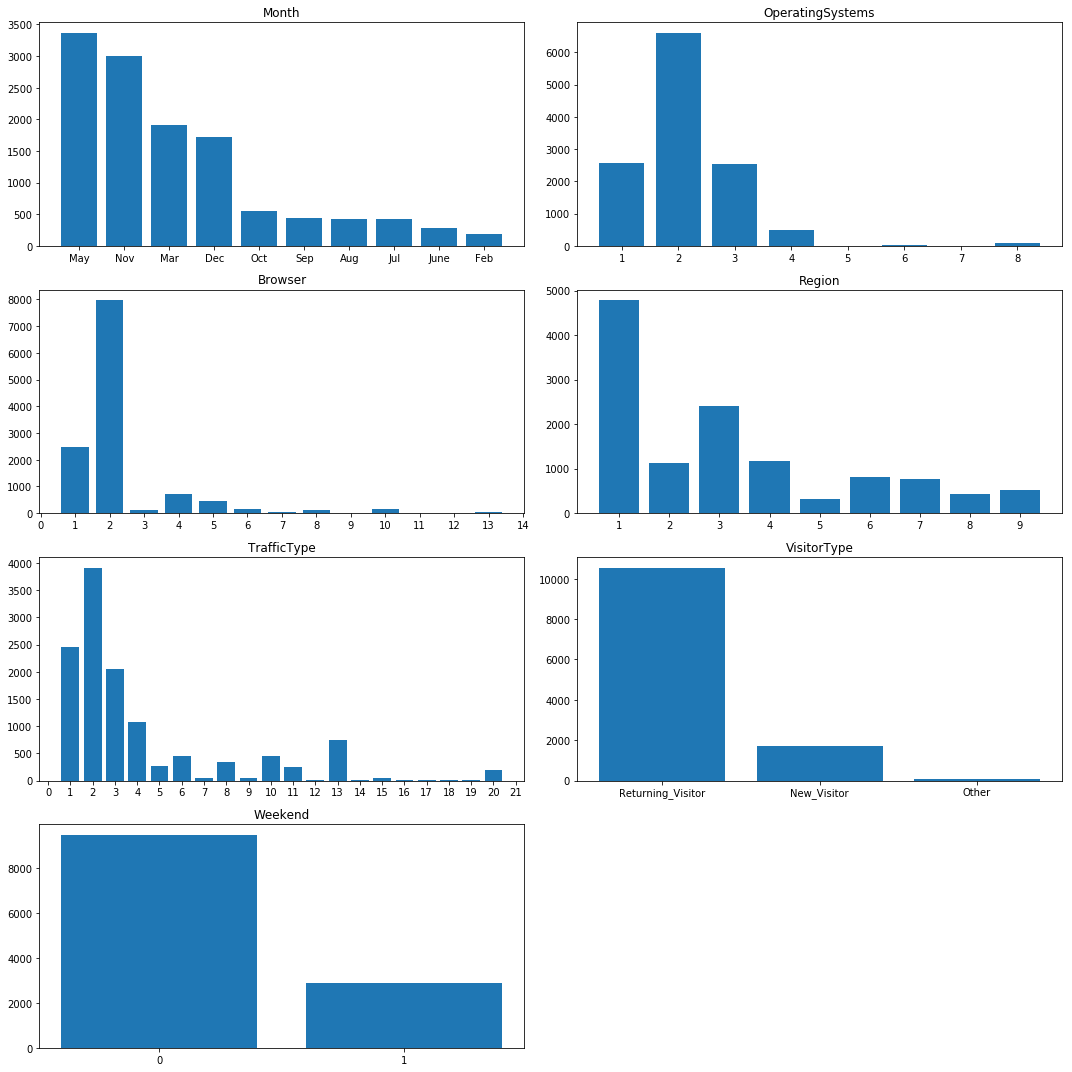

In [10]:
categorial_attr = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
# set figure size
fig = plt.figure(figsize=(15, 15))
i = 1

for f in categorial_attr:

    val_cnt = data[f].value_counts()

    plt.subplot(4, 2, i)
    plt.bar(x=val_cnt.index, height=val_cnt.values)
    plt.title(f)

    ax = plt.gca()
    major_locator = MultipleLocator(1)
    ax.xaxis.set_major_locator(major_locator)

    plt.tight_layout()



    i += 1

plt.show()

From these figures I found that categorial variables are not balanced. Some categories are more then others. The distributions are skewed.

What's more, month data only have 10 valid values, not 12.

And then the numerical variables

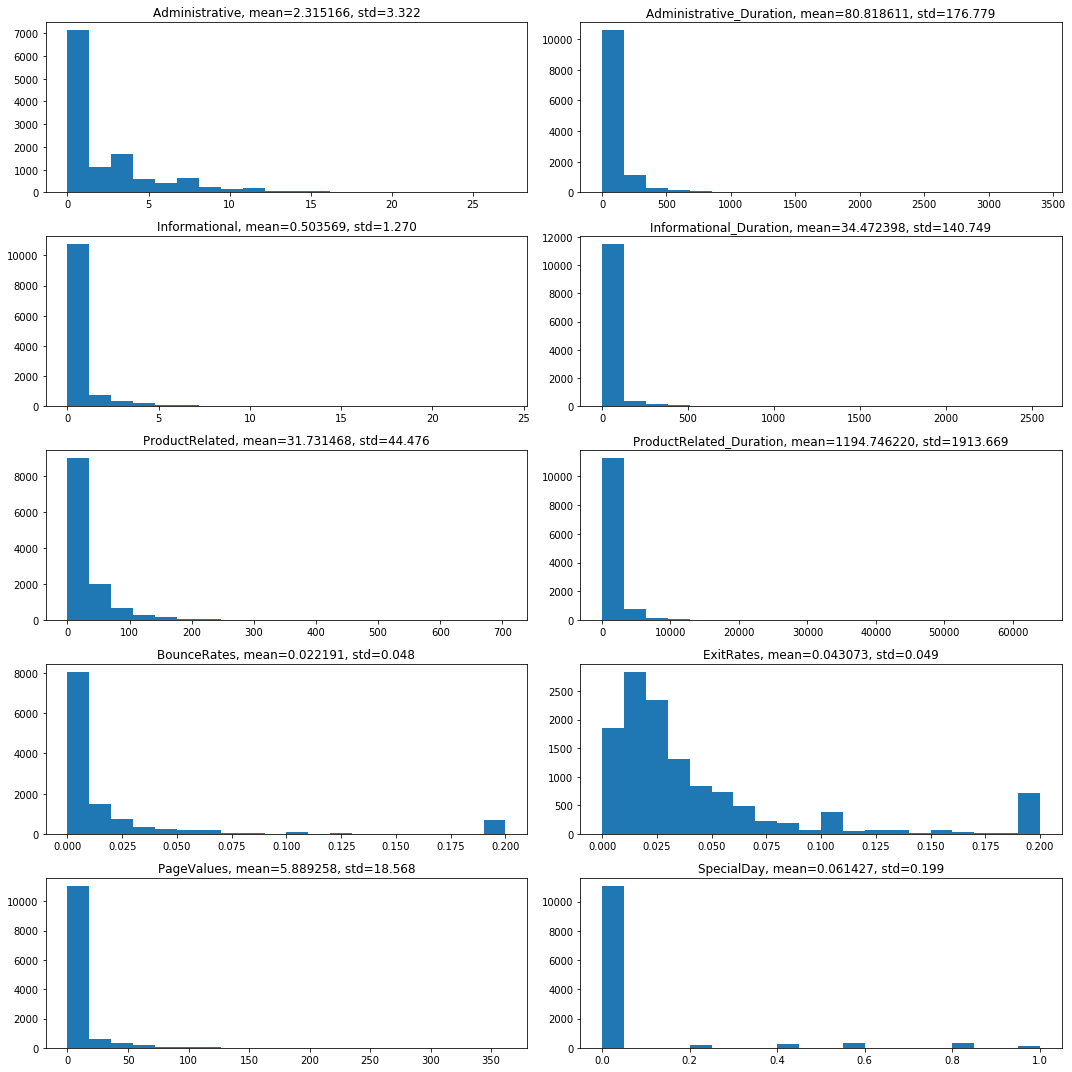

In [11]:
numerical_attr = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
# set figure size
fig = plt.figure(figsize=(15, 15))
i = 1

for f in numerical_attr:

    val_cnt = data[f].value_counts()

    plt.subplot(5, 2, i)
    plt.hist(data[f], bins=20)
    plt.title('{}, mean={:3f}, std={:.3f}'.format(f, data[f].mean(), data[f].std()))

    plt.tight_layout()


    i += 1

plt.show()

Numerical variables are also skewed. Number of small values (close to 0) are more than big values. 

## Data preparation

In this step I'll perform some data preparation work. As we can see there are lots of categorial data in the dataset which not suitable for cluster algorithms (not only non-numerical data, some categorial with numerical values also need convertion because their values can not compare with each other). So the main work in this step is convert data format. I'll convert categorial data to one-hot encoding. 

What's more, numerical variables are distributed in different range. I think change them into $[0, 1]$ is good for cluster. So I'll perform standardization to change ranges of numerical data.

Standardization on numerical variables. There are some "rate" data in numerical variables and their min value absolutely is 0 but their max value is unknown. The observed max value is 0.2 but for a "rate" data, bigger value is possible. So I'll use following formula to perform the Standardization.

In [12]:
num_var = data[numerical_attr].copy()

num_var = (num_var - num_var.mean()) / num_var.std()

print(num_var.mean())
print(num_var.std())

num_var = num_var.values

Administrative             2.531272e-16
Administrative_Duration    1.373419e-15
Informational              2.961225e-16
Informational_Duration    -7.668958e-16
ProductRelated             1.858025e-17
ProductRelated_Duration   -3.086474e-16
BounceRates                7.480346e-15
ExitRates                  1.909840e-14
PageValues                 6.860512e-16
SpecialDay                -3.280110e-16
dtype: float64
Administrative             1.0
Administrative_Duration    1.0
Informational              1.0
Informational_Duration     1.0
ProductRelated             1.0
ProductRelated_Duration    1.0
BounceRates                1.0
ExitRates                  1.0
PageValues                 1.0
SpecialDay                 1.0
dtype: float64


Now, all numerical variables have mean value closes to 0 and standard diviation equals to 1

Convert categorial data to one-hot encoding.

It is important to notice that `Month` only have 10 valid values in dataset. But the encoder have to process all 12 month in order to handle unseen month in unseen dataset.

In [13]:
enc = OneHotEncoder()
proc_data = num_var

for f in categorial_attr:

    # handle month data
    if f == 'Month':
        labels = ['June', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        label_enc = LabelEncoder()
        label_enc.fit(labels)
        label_tgt = label_enc.transform(data[f]).reshape((data.shape[0], -1))
        label_vals = np.arange(1, 13).reshape((12, -1))
        enc.fit(label_vals)
        tgt = enc.transform(label_tgt).toarray()

    else:
        cat_data = data[f].values.reshape((data.shape[0], -1))
        enc.fit(cat_data)
        tgt = enc.transform(cat_data).toarray()
    
    proc_data = np.hstack([proc_data, tgt])
print(proc_data.shape)

(12330, 77)


Now all data is suitable for cluster algorithms.

## Cluster

In this step I'll train a hierarchical cluster algorithm and implement a KMeans algorithm to perform cluster.

Using hierarchical cluster algorithm

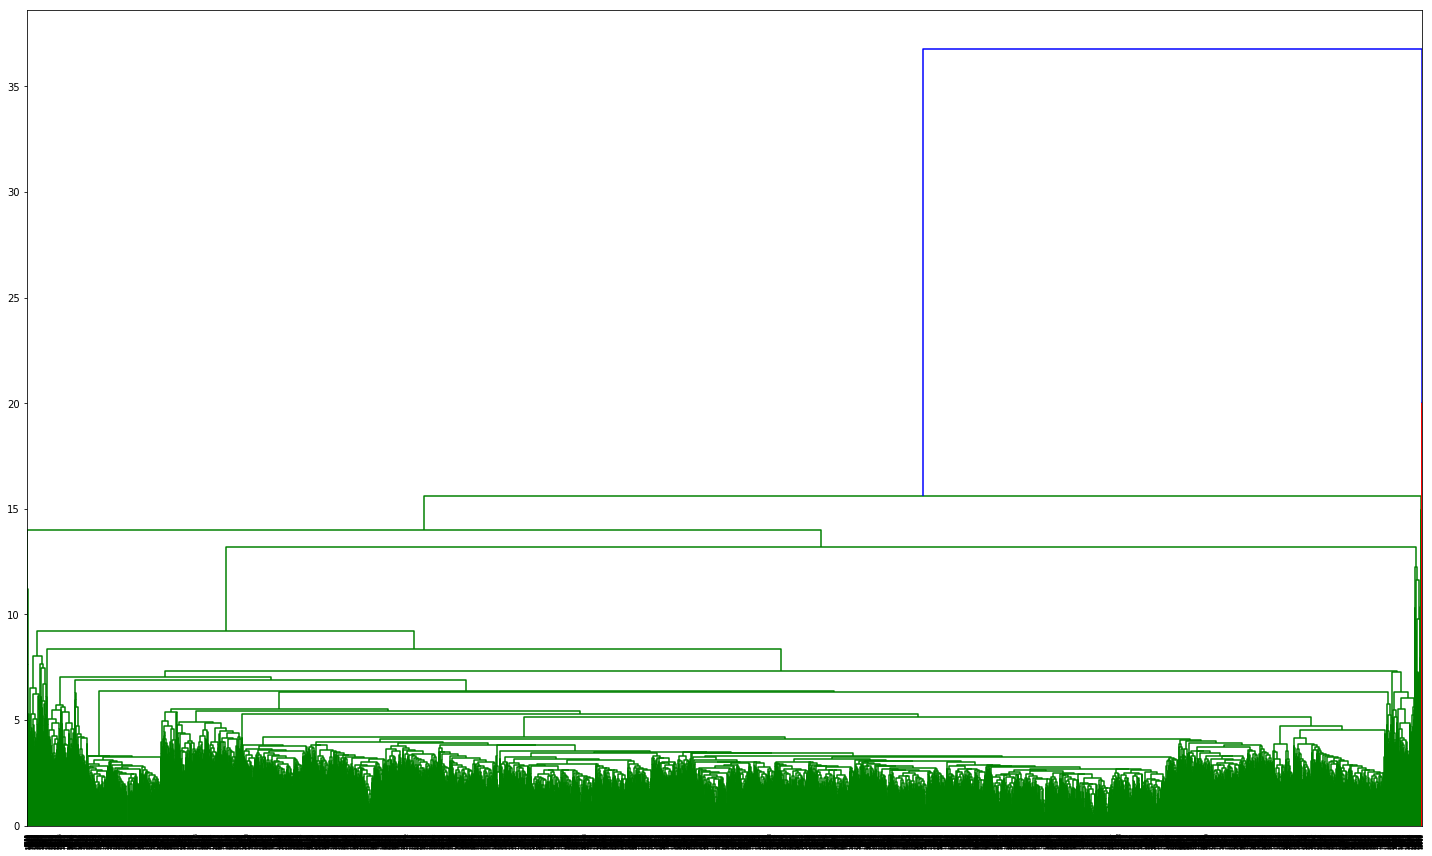

In [39]:
dis_mat = sch.distance.pdist(proc_data)
z = sch.linkage(dis_mat, method='average')

plt.figure(figsize=(25, 15))
p = sch.dendrogram(z)
plt.show()

Here is the dendrogram diagram. For the top level, dataset is clustered into several big clusters, and right edges of these clusters are most right edge. So I think 2 clusters should be imposed on the data because 2 clusters can cover all dataset and do not make the dataset too complex. 

And then, I'll implement a KMeans algorithm. I'll write 2 function to do KMeans, one for training and another for prediction.

In [15]:
# training function of KMeans

def KMeans_fit(X, n_clusters=2):

    # init center randomly
    index = np.random.choice(range(X.shape[0]), size=n_clusters, replace=False)
    centers = X[index]
    # malloc distance matrix 
    dist_mat = np.zeros((X.shape[0], n_clusters))
    # judge when to finish
    is_finish = False

    while not is_finish:

        is_finish = True

        # calculate distance between each item with each center
        for i in range(n_clusters):

            dist_mat[:, i] = np.sqrt(((X - centers[i, :])**2).sum(axis=1))

        cluster_mat = np.argmin(dist_mat, axis=1)

        # update centers
        for i in range(n_clusters):

            clus_item = X[cluster_mat == i, :]
            new_center = clus_item.mean(axis=0)

            # if center not change, end the loop
            if (centers[i, :] - new_center > 1e-5).sum() > 0:
                centers[i, :] = new_center
                is_finish = False
    return centers

In [16]:
# prediction function of KMeans
def KMeans_pred(X, centers):

    n_clusters = centers.shape[0]

    dist_mat = np.zeros((X.shape[0], n_clusters))

    for i in range(n_clusters):
        dist_mat[:, i] = np.sqrt(((X - centers[i, :])**2).sum(axis=1))
    
    cluster_mat = np.argmin(dist_mat, axis=1)
    inertia_mat = np.zeros(n_clusters)

    for i in range(n_clusters):
        inertia_mat[i] = dist_mat[cluster_mat == i, i].sum()


    return cluster_mat, inertia_mat.sum()

Now I'll use elbow plot and silhouette plot to determine the best K value. I'll search k in range $[2, 10]$ because too big K value makes no sense.

For each K value, I'll run KMeans several times and get average silhouette score to avoid random influence.

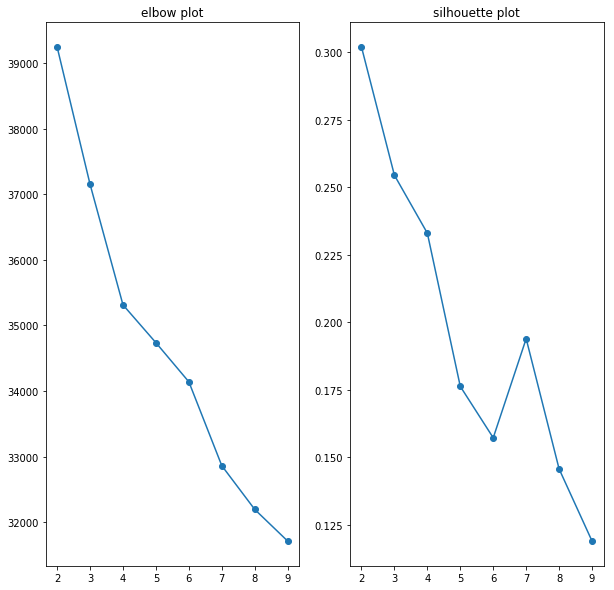

In [17]:
# plot the elbow and silhouette plot
sse = []
she = []

n_iter = 5

for k in range(2, 10):

    avg_inertia = 0
    avg_silhouette = 0

    for _ in range(n_iter):

        centers = KMeans_fit(proc_data, k)
        cluster, inertia = KMeans_pred(proc_data, centers)

        avg_inertia += inertia
        avg_silhouette += silhouette_score(proc_data, cluster)
    
    avg_inertia /= n_iter
    avg_silhouette /= n_iter

    sse.append(avg_inertia)
    she.append(avg_silhouette)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.plot(range(2, 10), sse, 'o-')
plt.title('elbow plot')

plt.subplot(122)
plt.plot(range(2, 10), she, 'o-')
plt.title('silhouette plot')
plt.show()


From the figures above we can see that silhouette score get maximum value when K value equals to 2. So 2 is the best K value.

Finally I'll apply $k=2$ to KMeans to group data into 2 group. And I'll add the cluster result to origin dataframe.

In [18]:
centers = KMeans_fit(proc_data, 2)
cluster, inertia = KMeans_pred(proc_data, centers)

new_col = pd.DataFrame(columns=['Revenue'], data=cluster)

new_data = data.copy()
new_data['Revenue'] = new_col


I'll read actual label data from file and compare them with my KMeans result.

Here are some EDA on each cluster. The EDA work is similar to what I have done on classification task. I'll explore distribution and relationship between each variable. But it is different that the response variable is derived from cluster algorithm.

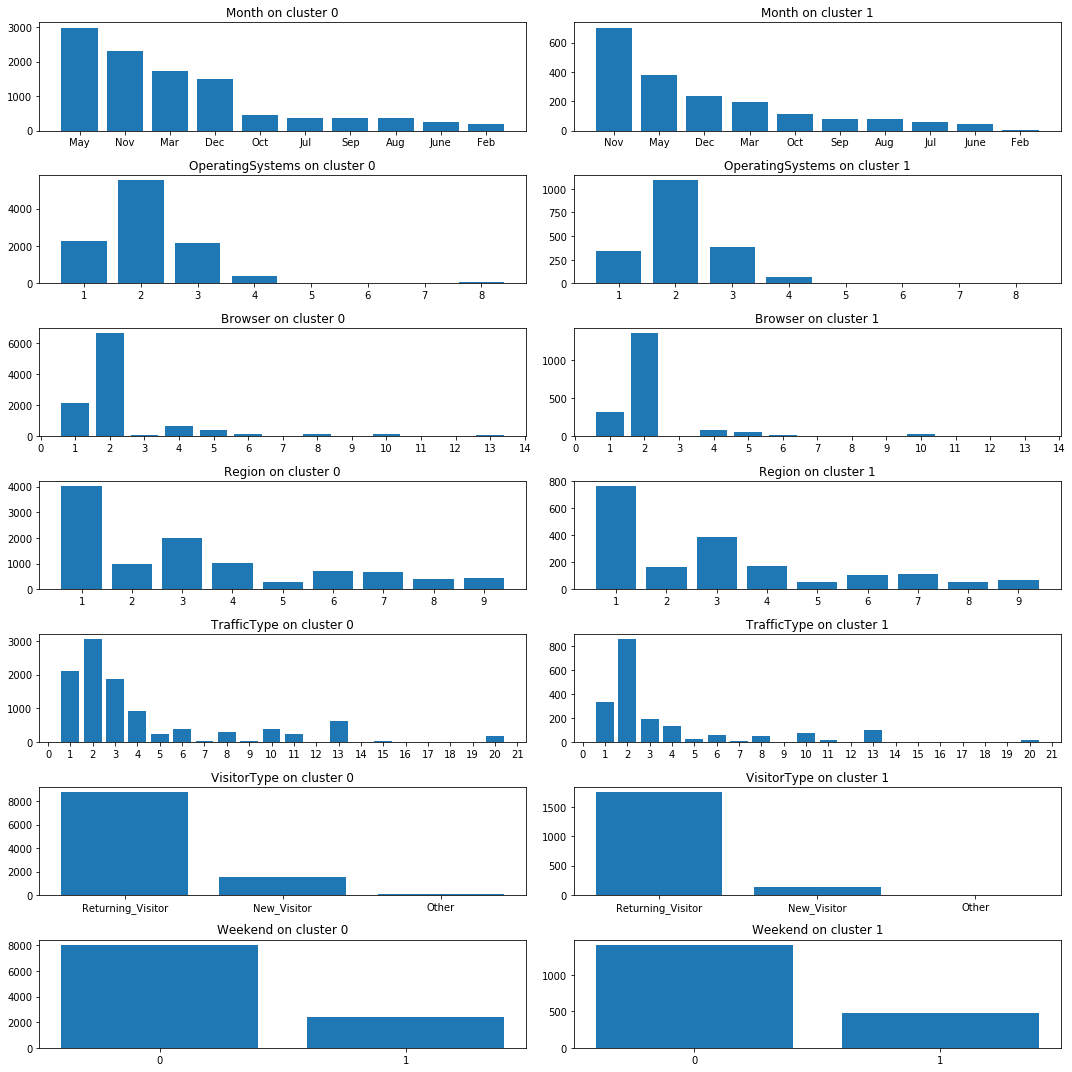

In [19]:
categorial_attr = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

fig = plt.figure(figsize=(15, 15))
i = 0

for f in categorial_attr:

    for k in range(2):

        gp_data = new_data[new_data.Revenue == k]

        val_cnt = gp_data[f].value_counts()

        plt.subplot(7, 2, 2 * i + k + 1)
        plt.bar(x=val_cnt.index, height=val_cnt.values)
        plt.title('{} on cluster {}'.format(f, k))

        ax = plt.gca()
        major_locator = MultipleLocator(1)
        ax.xaxis.set_major_locator(major_locator)

        plt.tight_layout()



    i += 1

plt.show() 

We can see that distribution of `Month`, `OperatingSystem` and `TrafficType` on cluster 0 is different from which on cluster 1.

/Users/TTzuo/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


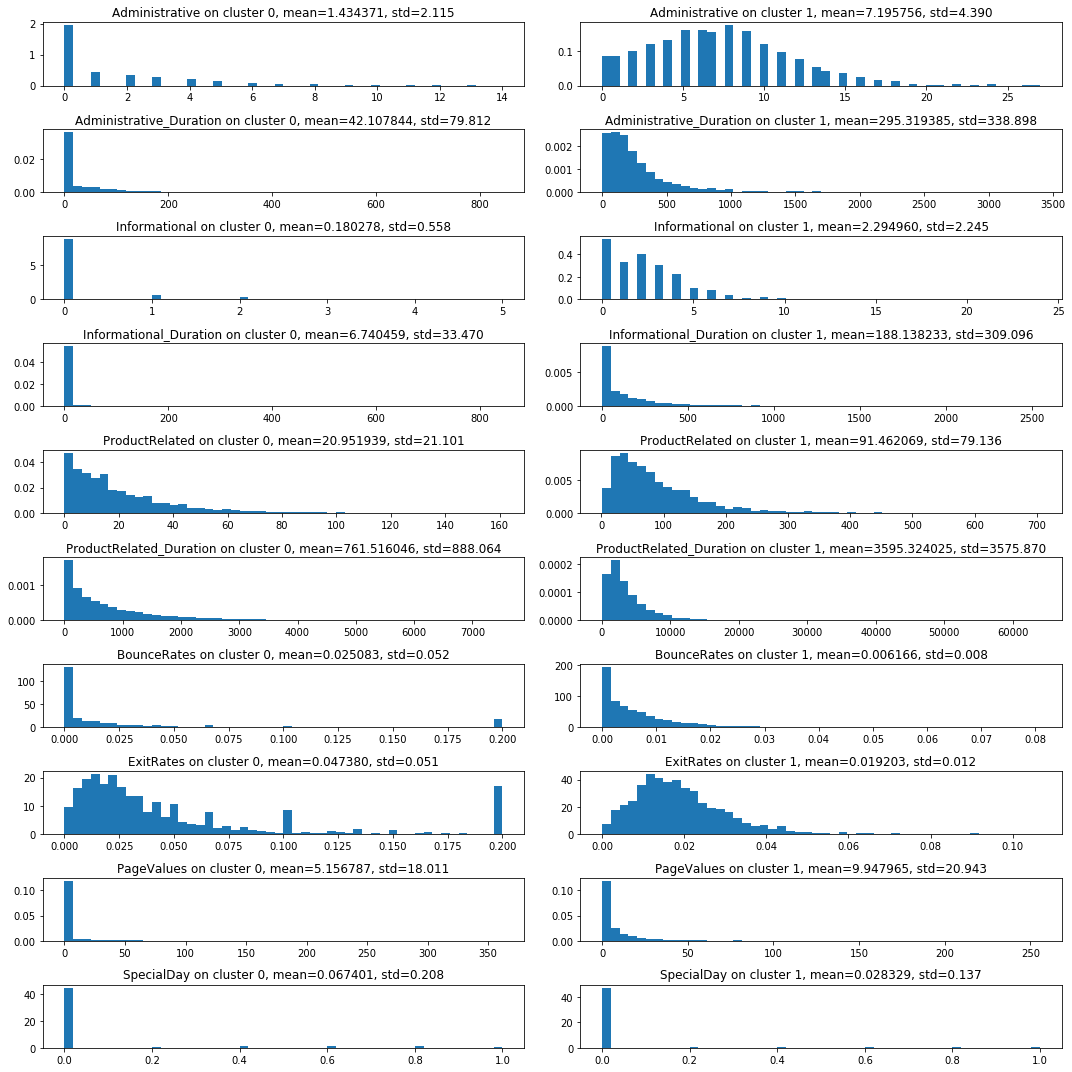

In [20]:
numerical_attr = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

fig = plt.figure(figsize=(15, 15))
i = 1

for f in numerical_attr:

    for k in range(2):

        gp_data = new_data[new_data.Revenue == k]

        val_cnt = gp_data[f].value_counts()

        plt.subplot(10, 2, i)
        plt.hist(gp_data[f], bins=50, normed=True)
        plt.title('{} on cluster {}, mean={:3f}, std={:.3f}'.format(f, k, gp_data[f].mean(), gp_data[f].std()))

        plt.tight_layout()


        i += 1

plt.show()

It is obviously that distribution of continuous variables are very different on cluster 0 and cluster 1 (also different on mean and std). It indicates that the `Revenue`, result of KMeans really detected some difference between each observations.

Here I read true label from file and add them to origin data.

In [22]:
label_data = pd.read_csv('https://raw.githubusercontent.com/TTZUO/DAV-6150/master/Project2_Data_Labels.csv')['Revenue']
label_data[label_data == True] = 1
label_data[label_data == False] = 0

new_data['V_Revenue'] = label_data

I'll use accuracy score to judge the performance of KMeans. If I regard the cluster result as classification result, confusion matrix may be help.

In [23]:
print(new_data['Revenue'].value_counts())
print(new_data['V_Revenue'].value_counts())

0    10445
1     1885
Name: Revenue, dtype: int64
0.0    10422
1.0     1908
Name: V_Revenue, dtype: int64


The value counts of cluster result is close to true label.

In [24]:
acc = (new_data['Revenue'] == new_data['V_Revenue']).sum() / new_data.shape[0]

print(acc)

0.7775344687753447


In [25]:
conf_mat = confusion_matrix(new_data.Revenue, new_data.V_Revenue)
print(conf_mat)

[[9062 1383]
 [1360  525]]


The result said that there are 75% results are same to true label. So cluster result is indicative of whether or not a visitor made a purchase.

## SVM training

The following part of this project is using SVM to do prediction. At first I'll do variable selection on dataset to get different model. 

At first is variable selection. According to my experience in previous assignment, using decision tree to do this work always get good result (it will generate a model with high generalization performance which work well on unseen observations). So I'll use decision tree this time.

What's more, the categorial variables have been converted to one-hot encoding before to fit in KMeans. So variable selection will perform on converted data which contains subvariables of categorial variables.

In [26]:
num_var = data[numerical_attr].copy()

enc = OneHotEncoder()

src_data = num_var

for f in categorial_attr:

    # handle month data
    if f == 'Month':
        labels = ['June', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        label_enc = LabelEncoder()
        label_enc.fit(labels)
        label_tgt = label_enc.transform(data[f]).reshape((data.shape[0], -1))
        label_vals = np.arange(1, 13).reshape((12, -1))
        enc.fit(label_vals)
        tgt = enc.transform(label_tgt).toarray()

    else:
        cat_data = data[f].values.reshape((data.shape[0], -1))
        enc.fit(cat_data)
        tgt = enc.transform(cat_data).toarray()
    
    src_data = np.hstack([src_data, tgt])

Now data is ready to use. I'll create 2 different dataset, one contains all variables as origin dataset while another using decision tree to select some variables.

In [27]:
data1 = src_data.copy()
data2 = src_data.copy()

In [28]:
# using decision tree to perform variable selection

dt = DecisionTreeClassifier()
dt.fit(src_data, new_data.Revenue.values)

feature_importance = dt.feature_importances_
print(feature_importance)

[2.32054159e-01 8.49174049e-02 3.55394149e-01 6.36766930e-02
 1.40586757e-01 8.27038685e-02 2.88857550e-03 6.47193184e-03
 6.89401893e-03 4.69682675e-04 8.44772017e-04 1.27858062e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.05368782e-04
 2.87028302e-04 7.30617495e-04 1.55612038e-03 1.55299229e-03
 1.44595166e-03 0.00000000e+00 9.39365351e-04 8.34991423e-04
 0.00000000e+00 1.02634362e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.96422445e-04 6.01193824e-04 5.49097620e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.17708657e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.17495711e-04
 3.13121784e-04 8.34991423e-04 1.61034060e-03 7.07607788e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.94931389e-04
 3.81767713e-04 4.17495711e-04 5.84493996e-04 8.96666926e-04
 0.00000000e+00 4.82729416e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00198971e-03 0.00000000e+00 0.00000000e+00
 1.98133558e-04 4.611429

I'll keep variables with importance greather then 0.001 (There are lots of 0 in importance vector and non-zero values are very small).

In [29]:
remaining_features = np.where(feature_importance >= 0.001)
print(remaining_features)
remaining_data = data2[:, remaining_features].reshape((data2.shape[0], -1))

print(remaining_data.shape)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 18, 19, 20, 25, 39, 46, 61]),)
(12330, 17)


And then, I'll perfrom train-test split. I'll split data1 and data2 to train set and test set with split ratio 0.7

In [30]:
indices = np.arange(data.shape[0])

In [31]:
X_train_1, X_test_1, y_train_1, y_test_1, idx_train_1, idx_train_2 = train_test_split(data1, new_data.Revenue.values, indices, train_size=0.7)

In [32]:
X_train_2, X_test_2, y_train_2, y_test_2, idx_train_2, idx_test_2 = train_test_split(remaining_data, new_data.Revenue.values, indices, train_size=0.7)

Now I'll train 2 SVM models on each dataset. After training, I'll use cross validation with $k=5$ to evaluate performance of each model on train set.

Finally, these models will run on test set and evaluate them on unseen observations. 

The accuracy of these models will be used to evaluate final performance.

SVM on dataset1, which contains all variables

In [33]:
import time

In [34]:
svm1 = SVC()
cv_acc_score = cross_val_score(svm1, X_train_1, y_train_1, cv=5, scoring=make_scorer(accuracy_score)).mean()
cv_precision = cross_val_score(svm1, X_train_1, y_train_1, cv=5, scoring=make_scorer(precision_score)).mean()
cv_recall = cross_val_score(svm1, X_train_1, y_train_1, cv=5, scoring=make_scorer(recall_score)).mean()
cv_f1 = cross_val_score(svm1, X_train_1, y_train_1, cv=5, scoring=make_scorer(f1_score)).mean()

print('acc=', cv_acc_score)
print('precision=', cv_precision)
print('recall=', cv_recall)
print('f1=', cv_f1)

acc= 0.9453137779698215
precision= 0.9020736804343829
recall= 0.7120738678878213
f1= 0.7958183863551455


In [35]:
tic = time.time()
svm1.fit(X_train_1, y_train_1)
toc = time.time()
print('Time comsumed: {}'.format(toc - tic))

pred = svm1.predict(X_test_1)
acc = accuracy_score(pred, y_test_1)
print(acc)

Time comsumed: 0.8730189800262451
0.9516085428494188


SVM on dataset 2, which undergo variable selection by decision tree.

In [36]:
svm2 = SVC()
cv_acc_score = cross_val_score(svm2, X_train_2, y_train_2, cv=5, scoring=make_scorer(accuracy_score)).mean()
cv_precision = cross_val_score(svm2, X_train_2, y_train_2, cv=5, scoring=make_scorer(precision_score)).mean()
cv_recall = cross_val_score(svm2, X_train_2, y_train_2, cv=5, scoring=make_scorer(recall_score)).mean()
cv_f1 = cross_val_score(svm2, X_train_2, y_train_2, cv=5, scoring=make_scorer(f1_score)).mean()

print('acc=', cv_acc_score)
print('precision=', cv_precision)
print('recall=', cv_recall)
print('f1=', cv_f1)

acc= 0.9483257861474865
precision= 0.921119418289349
recall= 0.7197534897534899
f1= 0.8073436197591665


In [37]:
tic = time.time()
svm2.fit(X_train_2, y_train_2)
toc = time.time()

print('Time comusmed: {}'.format(toc - tic))

pred = svm2.predict(X_test_2)
acc = accuracy_score(pred, y_test_2)
print(acc)

Time comusmed: 0.2851250171661377
0.9418761827520952


As we can see that both the 2 models gained excellent accuracy on train and test set, and they all performed high generalization performance (accuracy on test set higher then on train set). What's more, their precision and recall are similar, model 1 is a little better. But I think the best model is model 2 which trained on dataset which undergo variable selection. Because model 2 has a higher accuracy score on test set then model 1 and model 2 only used 7 explanatory variables, which is far less then model 1 (77). I know that SVM become slowly when it encounter a large scale dataset. So a model with fewer parameters and high performance is more effective. I printed the training time consumption and found that model 1 cost as twice as model 2 cost. 

So, model 2 gained a better performance on a smaller dataset and fewer runtime, it is the best model.

Now I'll compare SVM prediction result and V_Revenue.

In [38]:
true_label = new_data.V_Revenue.values[idx_test_2]
pred = svm2.predict(X_test_2)

acc = accuracy_score(true_label, pred)
conf_mat = confusion_matrix(true_label, pred)

print(acc)
print(conf_mat)

0.7912949445796161
[[2788  328]
 [ 444  139]]


SVM learnt 79% from cluster result because the accuracy between prediction result and `V_Revenue` is roughly 79%. The result is not very good but not bad. And from the confusion matrix I found that SVM seems hard to classify False categorial correctly because there are only 6 False items are classified correctly. And this is similar to confusion matrix derieved from cluster algorithm. This problem may be caused by cluster algorithm. 